In [ ]:
pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412 kB 4.1 MB/s 


## Importing libraries

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

##  Loading Dataset

In [ ]:
data = pd.read_csv("malicious_phish.csv")
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [ ]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [ ]:
data.tail()

,url,type
272411,facebook.com/people/Robert-Favreau/564397267,benign
272412,mylife.com/zip-codes/b3-30272/,benign
272413,https://twitter.com/share?url=http%3A%2F%2Fhub...,benign
272414,http://thenextweb.com/apps/2014/12/11/prezi-no...,benign
272415,http://www.pensiiilfov.ro/index.php?option=com...,NaN


In [ ]:
data = data.dropna()
data.isnull().sum()

url     0
type    0
dtype: int64

In [ ]:
count = data.type.value_counts()
count

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

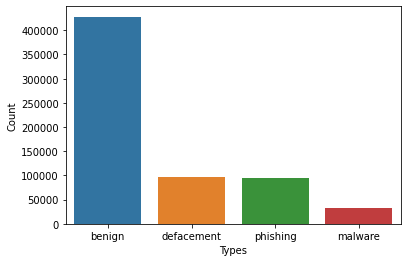

In [ ]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

**first have to omit the (www.) from the URL which is in fact a sub domain in itself.**

In [ ]:
data['url'] = data['url'].replace('www.', '', regex=True)
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)
data

,url,type,Category
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1
...,...,...,...
272410,nursegroups.com/CNA-Programs/California/Oakland,benign,0
272411,facebook.com/people/Robert-Favreau/564397267,benign,0
272412,mylife.com/zip-codes/b3-30272/,benign,0
272413,https://twitter.com/share?url=http%3A%2F%2Fhub...,benign,0


## Feature Extraction

In [ ]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))
data.head()

,url,type,Category,url_len
0,br-icloud.com.br,phishing,2,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235


In [ ]:
#res.parsed_url :-
# SplitResult(
#     scheme='http',
#     netloc='some.subdomain.google.co.uk',
#     path='',
#     query='',
#     fragment=''
# )  
###  more info :- https://pypi.org/project/tld/

def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [ ]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))
data.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [ ]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


**classifiying abnormal url**

In [ ]:
# how urlparse work : https://www.tutorialspoint.com/urllib-parse-parse-urls-into-components-in-python

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [ ]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1,1


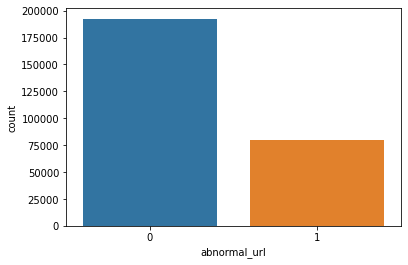

In [ ]:
sns.countplot(x='abnormal_url', data=data);

In [ ]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [ ]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1,1,0


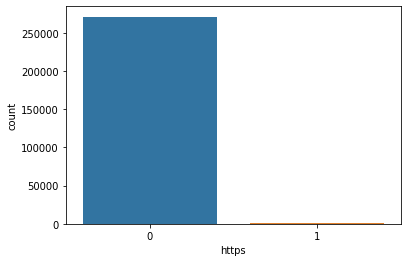

In [ ]:
sns.countplot(x='https', data=data);

**Counting the number of digit characters in a URL**


In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [ ]:
data['digits']= data['url'].apply(lambda i: digit_count(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,%,+,$,!,*,",",//,abnormal_url,https,digits
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,0,0,0,1,1,0,7
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,0,0,1,1,0,22


**Counting the number of letter characters in a URL**

In [ ]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [ ]:
data['letters']= data['url'].apply(lambda i: letter_count(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,+,$,!,*,",",//,abnormal_url,https,digits,letters
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,0,1,25
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,0,0,1,1,0,7,60
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,0,1,1,0,22,199


**Checking to see whether URL contains a shortening service**

In [ ]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [ ]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,$,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,13,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,1,29,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,1,25,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,0,1,1,0,7,60,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,1,1,0,22,199,0


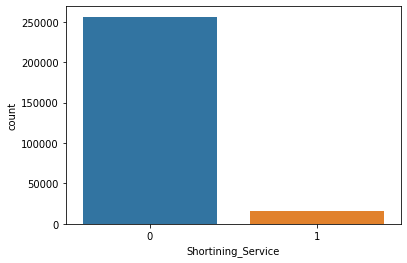

In [ ]:
sns.countplot(x='Shortining_Service', data=data);

In [ ]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [ ]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,1,25,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,1,1,0,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,1,1,0,22,199,0,0


In [ ]:
data['having_ip_address'].value_counts()

0    272236
1       179
Name: having_ip_address, dtype: int64

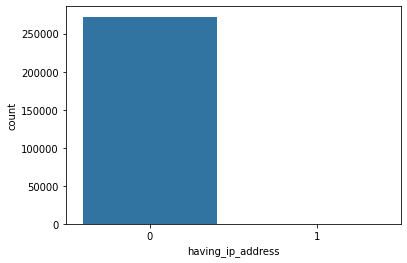

In [ ]:
sns.countplot(x='having_ip_address', data=data);

### Heatmap

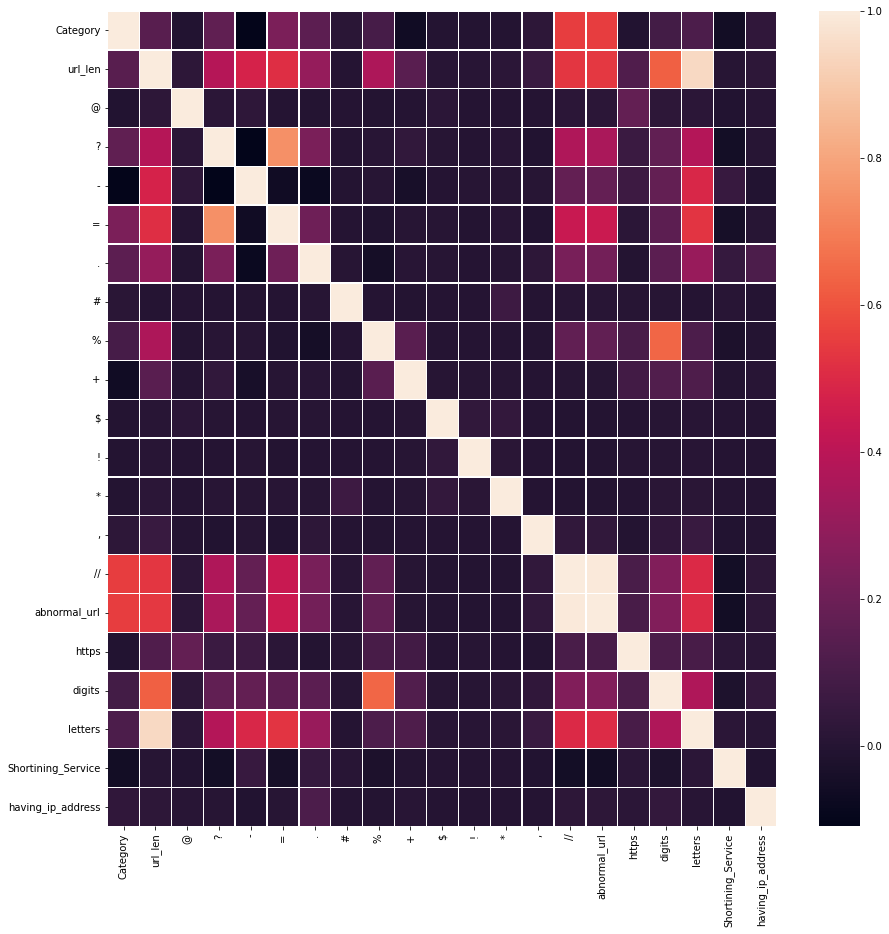

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), linewidths=.4)